In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import wandb
from sklearn.metrics import accuracy_score
from datasets import Dataset, ClassLabel, Value
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import DatasetDict
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
os.listdir("/kaggle/input/")

['preprocessed-single-label-csv']

In [64]:
df = pd.read_csv("/kaggle/input/preprocessed-single-label-csv/preprocessed_single_label.csv", index_col=0)
list_genres = ["Blues", "Gospel/Religioso", "Heavy Metal", "Jazz", "Rap"]
df = df[df["Genres"].isin(list_genres)]

In [65]:
df.rename_axis("id", inplace=True)
df.index = df.index.astype("int64")
df.Titel = df.Titel.astype("string")
df.Lyric = df.Lyric.astype("string")
df.Artist = df.Artist.astype("string")
df.Genres = pd.Categorical(df.Genres)
df.dropna(inplace=True)
df.dtypes

Titel     string[python]
Lyric     string[python]
Artist    string[python]
Genres          category
dtype: object

In [66]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)
labels = df["Genres"].values.unique()
labels

['Blues', 'Gospel/Religioso', 'Heavy Metal', 'Jazz', 'Rap']
Categories (5, object): ['Blues', 'Gospel/Religioso', 'Heavy Metal', 'Jazz', 'Rap']

In [67]:
#accuracy_score(df[:1000]["Genres"],df[:1000].apply(lambda x: classifier(x["Lyric"], labels)["labels"][0], axis=1))

In [68]:
unique_genres = pd.unique(df['Genres'])  # Ensures a consistent order
genre_to_index = {genre: idx for idx, genre in enumerate(unique_genres)}
df['Genres'] = df['Genres'].apply(lambda x: genre_to_index[x])

In [69]:
print(df['Lyric'].apply(type).value_counts())

Lyric
<class 'str'>    10255
Name: count, dtype: int64


In [70]:
df.Genres = df.Genres.cat.codes

dataset = Dataset.from_pandas(df)
features = dataset.features.copy()
features["Genres"] = ClassLabel(names=unique_genres.tolist())
features["Lyric"] = Value("string")

dataset= dataset.cast(features)
print(dataset)

Casting the dataset:   0%|          | 0/10255 [00:00<?, ? examples/s]

Dataset({
    features: ['Titel', 'Lyric', 'Artist', 'Genres', 'id'],
    num_rows: 10255
})


In [71]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def encode(batch):
    encoded = tokenizer(batch['Lyric'], truncation=True, padding='max_length', max_length=512)
    encoded['labels'] = batch['Genres']
    return encoded

dataset = dataset.map(encode, batched=True, num_proc = 7)

Map (num_proc=7):   0%|          | 0/10255 [00:00<?, ? examples/s]

In [72]:
num_labels = len(unique_genres)
train_test_split = dataset.train_test_split(test_size = 0.2)
## adding a validation set
dataset = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

In [73]:
print(dataset['train'][0])

{'Titel': 'His Eye Is On The Sparrow', 'Lyric': 'discouraged shadows come heart lonely long heaven home jesus portion constant friend eye sparrow know watches sing im happy sing im free eye sparrow know watches let heart troubled tender word hear resting goodness lose doubts fears sing im happy sing im free eye sparrow know watches though path leadeth one step may see eye sparrow know watches sing im happy sing im free eye sparrow know watches eye sparrow know watches', 'Artist': 'Newsboys', 'Genres': 1, 'id': 112816, 'input_ids': [101, 22585, 6281, 2272, 2540, 9479, 2146, 6014, 2188, 4441, 4664, 5377, 2767, 3239, 19479, 2113, 12197, 6170, 10047, 3407, 6170, 10047, 2489, 3239, 19479, 2113, 12197, 2292, 2540, 11587, 8616, 2773, 2963, 8345, 15003, 4558, 13579, 10069, 6170, 10047, 3407, 6170, 10047, 2489, 3239, 19479, 2113, 12197, 2295, 4130, 2599, 11031, 2028, 3357, 2089, 2156, 3239, 19479, 2113, 12197, 6170, 10047, 3407, 6170, 10047, 2489, 3239, 19479, 2113, 12197, 3239, 19479, 2113, 12

In [74]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    conf_matrix = confusion_matrix(labels, predictions)
    
    conf_matrix_list = conf_matrix.tolist()  # Convert the NumPy array to a list for JSON serialization during training
    
    return {
        "accuracy": acc,
        "confusion_matrix": conf_matrix_list  # Ensure the output is JSON serializable
    }

In [75]:
'''class MyCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        # Ensure any custom state saved is serializable
        if hasattr(state, 'some_custom_attribute'):
            state.some_custom_attribute = np.array(state.some_custom_attribute).tolist()
'''

"class MyCallback(TrainerCallback):\n    def on_train_begin(self, args, state, control, **kwargs):\n        # Ensure any custom state saved is serializable\n        if hasattr(state, 'some_custom_attribute'):\n            state.some_custom_attribute = np.array(state.some_custom_attribute).tolist()\n"

In [76]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels, ignore_mismatched_sizes=True)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    evaluation_strategy="epoch",     # evaluation strategy to adopt during training
    save_strategy="epoch",           # save strategy
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics = compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [77]:
trainer.train()
results = trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Confusion Matrix
1,0.431200,0.420313,0.874695,"[[159, 2, 10, 18, 11], [10, 213, 32, 19, 7], [26, 10, 810, 19, 34], [25, 11, 10, 229, 6], [3, 0, 1, 3, 383]]"
2,0.251000,0.438546,0.894686,"[[164, 4, 11, 20, 1], [8, 221, 37, 11, 4], [22, 7, 853, 13, 4], [23, 15, 15, 227, 1], [6, 1, 8, 5, 370]]"
3,0.121200,0.515108,0.891273,"[[160, 5, 12, 18, 5], [8, 231, 29, 7, 6], [25, 12, 839, 10, 13], [29, 14, 16, 221, 1], [3, 0, 8, 2, 377]]"


In [78]:
print(results)

{'eval_loss': 0.5151075124740601, 'eval_accuracy': 0.8912725499756217, 'eval_confusion_matrix': [[160, 5, 12, 18, 5], [8, 231, 29, 7, 6], [25, 12, 839, 10, 13], [29, 14, 16, 221, 1], [3, 0, 8, 2, 377]], 'eval_runtime': 20.5096, 'eval_samples_per_second': 100.002, 'eval_steps_per_second': 6.29, 'epoch': 3.0}


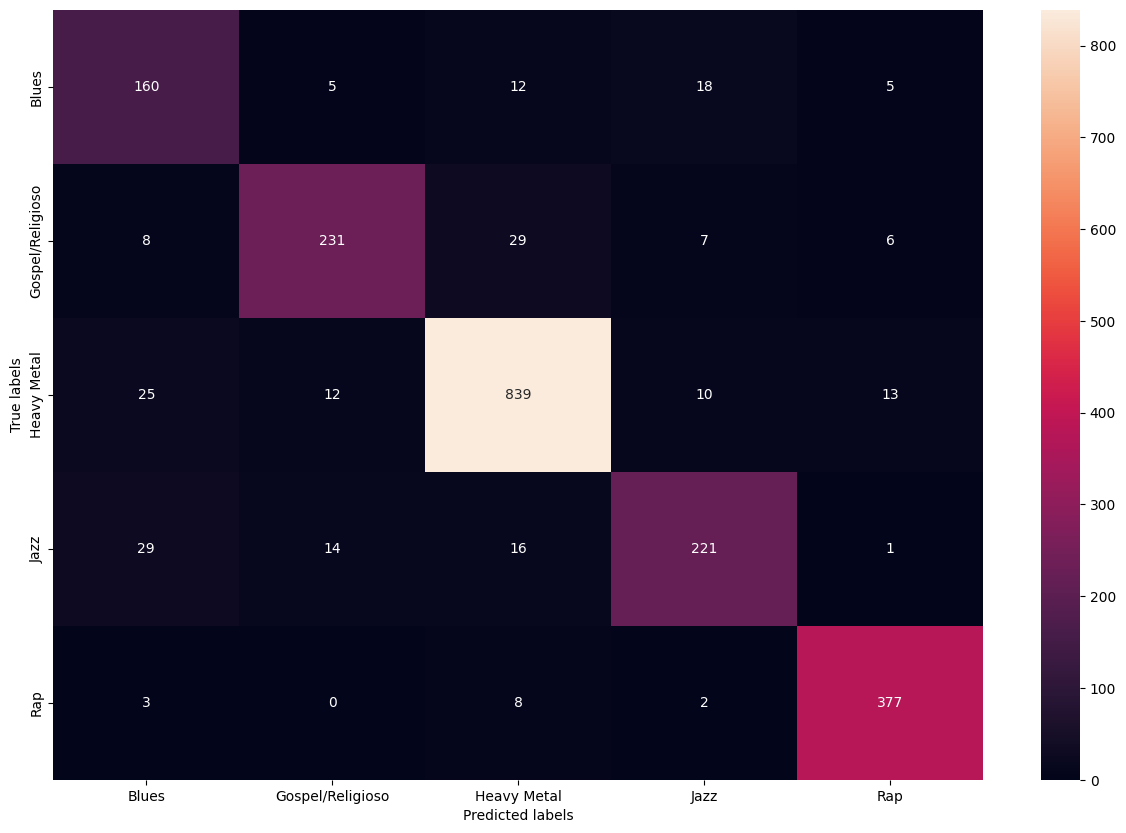

In [81]:
# plot the predictions into a confusion matrix already created in the compute metric method
conf_matrix = results['eval_confusion_matrix']

index_to_genre = {index: genre for index, genre in enumerate(unique_genres)}

# Map the indices in the confusion matrix to genre names
genre_names = [index_to_genre[i] for i in range(len(unique_genres))]

plt.figure(figsize=(15,10))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [82]:
results['eval_accuracy']

0.8912725499756217

In [83]:
def predict_genre(lyrics):
    # Define a function to make a prediction about a single lyric
    device = model.device
    inputs = tokenizer(lyrics, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    prediction = outputs.logits.argmax(-1)
    return dataset['train'].features['Genres'].int2str(prediction.item())

In [84]:
test_df = dataset["test"].to_pandas()
test_df["Decoded_Genres"] = test_df["Genres"].map(lambda x: unique_genres[x])
accuracy_score(test_df["Lyric"].apply(lambda x : predict_genre(x)), test_df["Decoded_Genres"])

0.8912725499756217